In [42]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from sklearn import tree
from IPython.display import Image
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.under_sampling import NearMiss

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


In [43]:
df = pd.read_csv('datatraining.txt')
test = pd.read_csv('datatest.txt')

### DATA PREPARATION

In [44]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [45]:
dates = pd.to_datetime(df['date'], infer_datetime_format=True)
df['day'] = dates.dt.day
df['hour'] = dates.dt.hour

In [46]:
weekend = []
for i in df.day:
    if i == 7 or i == 8:
        weekend.append(1)
    else:
        weekend.append(0)
weekend = pd.Series(weekend)
df['weekend'] = weekend

In [47]:
day_moment = []
for i in df.hour:
    if i > 6 and i <= 12:
        day_moment.append('morning')
    elif i > 12 and i <= 18:
        day_moment.append('afternoon')
    elif i > 18 and i <= 24:
        day_moment.append('evening')
    else:
        day_moment.append('night')
print(len(df))
print()
print(len(day_moment))

8143

8143


In [48]:
df['day_moment'] = day_moment

In [49]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,weekend,day_moment
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,4,17,0.0,afternoon
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,4,17,0.0,afternoon
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,4,17,0.0,afternoon
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,4,17,0.0,afternoon
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,4,17,0.0,afternoon


In [50]:
df.drop(['date', 'day', 'hour'], axis = 1, inplace = True)

### PREPROCESSING: ONE HOT ENCODING DI DAY MOMENT

#### ONE HOT ENCODING ALLA BRUTTO GESU' PERCHE' NON MI GIRA LA FUNZIONE DI GUIDOTTI

In [51]:
cat_afternoon = []
for i in df.day_moment:
    if i == 'afternoon':
        cat_afternoon.append(1)
    else:
        cat_afternoon.append(0)
df['afternoon'] = cat_afternoon
cat_morning = []
for j in df.day_moment:
    if j == 'morning':
        cat_morning.append(1)
    else:
        cat_morning.append(0)
df['morning'] = cat_morning
cat_evening = []
for k in df.day_moment:
    if k == 'evening':
        cat_evening.append(1)
    else:
        cat_evening.append(0)
df['evening'] = cat_evening
cat_night = []
for y in df.day_moment:
    if y == 'night':
        cat_night.append(1)
    else:
        cat_night.append(0)
df['night'] = cat_night

print(len(df['afternoon']))
print()
print(len(df['morning']))
print()
print(len(df['evening']))
print()
print(len(df['night']))

8143

8143

8143

8143


In [52]:
df.drop(['day_moment'], axis = 1, inplace = True)

### PREPARO IL TEST PERCHE' DEVE ESSERE IDENTICO AL TRAIN 

In [53]:
dates = pd.to_datetime(test['date'], infer_datetime_format=True)
test['day'] = dates.dt.day
test['month'] = dates.dt.month
test['year'] = dates.dt.year
test['hour'] = dates.dt.hour

In [54]:
test = test.reset_index(drop = True)
test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,month,year,hour
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,2,2,2015,14
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,2,2,2015,14
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,2,2,2015,14
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,2,2,2015,14
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,2,2,2015,14


In [55]:
print(test.day.min(), test.day.max())

2 4


In [56]:
### I GIORNI DEL TEST SONO TUTTI INFRASETTIMANALI

In [57]:
weekend = []
for d in range(len(test)):
    weekend.append(0)
test['weekend'] = weekend
print(len(test['weekend']))

2665


In [58]:
day_moment = []
for i in test.hour:
    if i > 6 and i <= 12:
        day_moment.append('morning')
    elif i > 12 and i <= 18:
        day_moment.append('afternoon')
    elif i > 18 and i <= 24:
        day_moment.append('evening')
    else:
        day_moment.append('night')
test['day_moment'] = day_moment
print(len(test))
print()
print(len(day_moment))

2665

2665


### ONE HOT ENCODING SEMPRE ALLA BRUTTO GESU'

In [59]:
cat_afternoon = []
for i in test.day_moment:
    if i == 'afternoon':
        cat_afternoon.append(1)
    else:
        cat_afternoon.append(0)
test['afternoon'] = cat_afternoon
cat_morning = []
for j in test.day_moment:
    if j == 'morning':
        cat_morning.append(1)
    else:
        cat_morning.append(0)
test['morning'] = cat_morning
cat_evening = []
for k in test.day_moment:
    if k == 'evening':
        cat_evening.append(1)
    else:
        cat_evening.append(0)
test['evening'] = cat_evening
cat_night = []
for y in test.day_moment:
    if y == 'night':
        cat_night.append(1)
    else:
        cat_night.append(0)
test['night'] = cat_night

print(len(test['afternoon']))
print()
print(len(test['morning']))
print()
print(len(test['evening']))
print()
print(len(test['night']))

2665

2665

2665

2665


In [60]:
test.drop(['date', 'day', 'hour','month','year', 'day_moment'], axis = 1, inplace = True)

In [61]:
test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,weekend,afternoon,morning,evening,night
0,23.7000,26.272,585.200000,749.200000,0.004764,1,0,1,0,0,0
1,23.7180,26.290,578.400000,760.400000,0.004773,1,0,1,0,0,0
2,23.7300,26.230,572.666667,769.666667,0.004765,1,0,1,0,0,0
3,23.7225,26.125,493.750000,774.750000,0.004744,1,0,1,0,0,0
4,23.7540,26.200,488.600000,779.000000,0.004767,1,0,1,0,0,0


In [62]:
df.dropna(axis = 0, inplace = True)

## DOPO LO SMINCHIAMENTO DEL PREPROCESSING COMINCIAMO COL DECISION TREE

#### GRID SEARCH: le prime due caselle non so a che servano onestamente.. però quel pca... BOOOOHH

In [63]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(df.drop(['Occupancy'], axis=1),df.Occupancy)

In [64]:
pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier()

In [65]:
sc = StandardScaler()

In [66]:
pipe = Pipeline(steps=[('sc', sc), ('decisiontree', decisiontree)])

In [67]:
n_components = list(range(1,X_train.shape[1]+1,1))

In [68]:
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10]

In [69]:
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

In [70]:
clf = GridSearchCV(pipe, parameters)

In [71]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                             

In [72]:
# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
# print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=4, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: entropy
Best max_depth: 6

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.97723729 0.9703773  0.99968818 0.95260368]

0.974976613657624

0.01686323043070427


### DECISION TREE CON I PARAMETRI TROVATI DA GRID SEARCH

In [73]:
clf = DecisionTreeClassifier(ccp_alpha = 0.0, class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf = clf.fit(X_train, y_train)

In [74]:
X_test = test.drop(['Occupancy'], axis=1)

In [75]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [76]:
for col, imp in zip(X_test.columns, clf.feature_importances_):
    print(col, imp)
    
cols = [(col) for col, imp in zip(X_test.columns, clf.feature_importances_) if imp == 0]
print(cols)

Temperature 0.013316733893611243
Humidity 0.0013994537992899465
Light 0.9602968618361323
CO2 0.024452264111807634
HumidityRatio 0.0
weekend 0.000534686359158909
afternoon 0.0
morning 0.0
evening 0.0
night 0.0
['HumidityRatio', 'afternoon', 'morning', 'evening', 'night']


In [77]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test.columns,
                                class_names=['IsBadBuy' if x == 1 else 'IsNotBadBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [78]:
y_test = test.Occupancy

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='binary', pos_label=0))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s\n' % f1_score(y_test, y_pred, pos_label=0))

print('Classification report train:')
print(classification_report(y_train, y_pred_tr))

print('Classification report test:')
print(classification_report(y_test, y_pred))

print('precision recall f1 support:')
print(precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=0))
print()

print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.9960243217960711
Train F1-score 0.9960128215151279

Test Accuracy 0.9639774859287055
Test F1-score 0.9715302491103204

Classification report train:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6414
           1       0.99      1.00      1.00      6414

    accuracy                           1.00     12828
   macro avg       1.00      1.00      1.00     12828
weighted avg       1.00      1.00      1.00     12828

Classification report test:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1693
           1       0.94      0.96      0.95       972

    accuracy                           0.96      2665
   macro avg       0.96      0.96      0.96      2665
weighted avg       0.96      0.96      0.96      2665

precision recall f1 support:
(0.9755807027992853, 0.96751329001772, 0.9715302491103204, None)

Confusion matrix:
[[6370   44]
 [   7 6407]]


## CROSS VALIDATION... boooohh

In [81]:
from sklearn.model_selection import cross_val_score

In [82]:
scores = cross_val_score(clf, X_train, y_train, cv=100)
scores

array([0.99224806, 1.        , 1.        , 1.        , 0.87596899,
       0.99224806, 1.        , 1.        , 0.99224806, 1.        ,
       1.        , 1.        , 0.8372093 , 0.68992248, 0.98449612,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99224806, 1.        , 1.        , 1.        ,
       0.99224806, 0.93023256, 0.95348837, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.796875  , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9921875 , 1.        , 0.9921875 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [83]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
scores

array([0.97270624, 0.99337473, 0.94488424, 0.96565249, 0.59909541])

In [84]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
scores

array([0.9731099 , 0.9933749 , 0.94505066, 0.96569201, 0.95204678])

In [85]:
scores = cross_val_score(clf, X_train, y_train, cv=100, scoring='f1')
scores

array([0.99224806, 1.        , 1.        , 1.        , 0.85964912,
       0.99224806, 1.        , 1.        , 0.99224806, 1.        ,
       1.        , 1.        , 0.86092715, 0.76470588, 0.98461538,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99212598, 1.        , 1.        , 1.        ,
       1.        , 0.93430657, 0.95522388, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.83116883, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99212598, 1.        , 0.99212598, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

### TUNING DEI PARAMETRI: profondità massima con AUC e f1 score

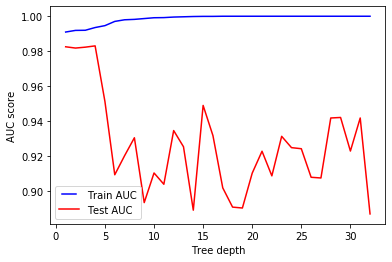

In [86]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

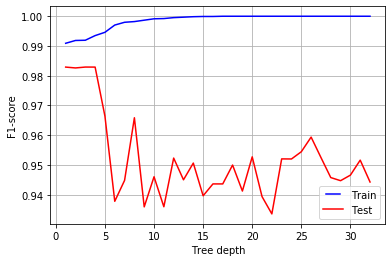

In [87]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   f1_train=f1_score(y_train, train_pred, average= 'binary', pos_label=0)
   train_results.append(f1_train) 
   
   y_pred = dt.predict(X_test)
   f1_test=f1_score(y_test, y_pred, average='binary', pos_label=0)
   test_results.append(f1_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.grid()
plt.ylabel('F1-score')
plt.xlabel('Tree depth')
plt.show()

## ROC CURVE

In [90]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

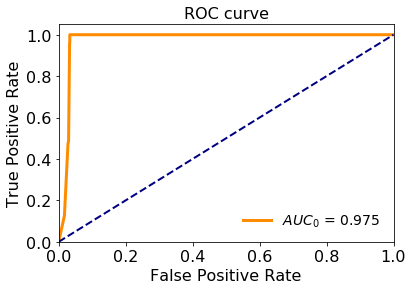

In [91]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()